In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


drive.mount('/content/drive')

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


#Part 1

##Part 1.1

###Part 1. 1 a - Import and read ‘images.npy’.



In [3]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/CV Project/images.npy',allow_pickle=True)
print(data.shape)

(409, 2)


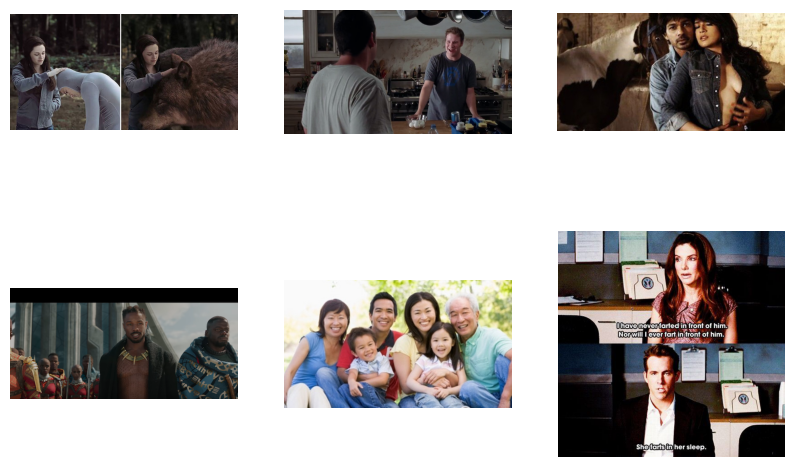

In [4]:
plt.figure(figsize=(10, 10))
for i in range(0,6):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(data[i][0], cmap='gray')
  plt.axis("off")

plt.show()


###- Part 1.1 b - Split the data into Features(X) & labels(Y). Unify shape of all the images

In [5]:
import numpy as np
import cv2


X = []
Y = []

height, width = 224, 224

# Extract images and masks from data
for item in data:
    image = cv2.resize(item[0], (width, height))

    # Ensure the image has 3 channels
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Add check for shape
    if image.shape != (height, width, 3):
        print("Skipped an image due to shape mismatch")
        continue

    X.append(image)

    mask = np.zeros((height, width))
    for annotation in item[1]:
        x1 = int(annotation['points'][0]['x'] * width)
        y1 = int(annotation['points'][0]['y'] * height)
        x2 = int(annotation['points'][1]['x'] * width)
        y2 = int(annotation['points'][1]['y'] * height)

        # Marking the region with 1
        mask[y1:y2, x1:x2] = 1

    Y.append(mask)

X = np.array(X, dtype=np.uint8)
Y = np.array(Y, dtype=np.uint8).reshape(-1, height, width, 1)

print(X.shape)
print(Y.shape)


Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
Skipped an image due to shape mismatch
(398, 224, 224, 3)
(398, 224, 224, 1)


In [6]:
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [7]:
X = X / 255.0

###Part 1.1 c - Split the data into train and test [400:9].

In [8]:
train_size = 400 / (400 + 9)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_size, shuffle=True, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (389, 224, 224, 3)
X_test shape: (9, 224, 224, 3)
Y_train shape: (389, 224, 224, 1)
Y_test shape: (9, 224, 224, 1)


###Part 1.1 d - Select random image from the train data and display original image and masked image.

In [9]:
def apply_mask(image, mask_data):
    mask = np.zeros_like(image)

    for face_data in mask_data:
        x1 = int(face_data['points'][0]['x'] * face_data['imageWidth'])
        y1 = int(face_data['points'][0]['y'] * face_data['imageHeight'])
        x2 = int(face_data['points'][1]['x'] * face_data['imageWidth'])
        y2 = int(face_data['points'][1]['y'] * face_data['imageHeight'])

        mask[y1:y2, x1:x2] = 1

    masked_image = np.multiply(image, mask)  # Element-wise multiplication
    return masked_image

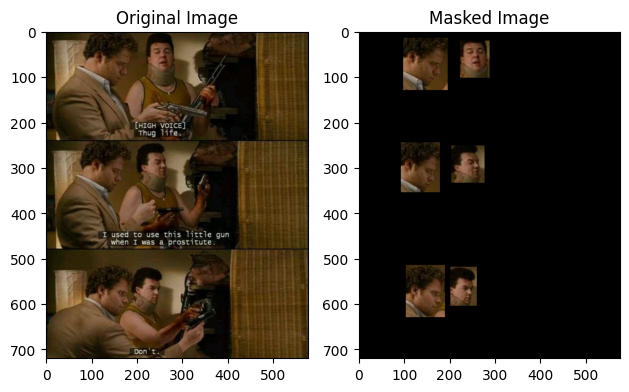

In [10]:
random_idx = np.random.randint(0, len(X_train))

random_image_data = data[random_idx]
random_image = random_image_data[0]
random_field = random_image_data[1]
plt.imshow(random_image, cmap='gray')

# Step 2: Display the original image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(random_image, cmap='gray')
plt.title('Original Image')

random_image_data = data[random_idx]
random_image = random_image_data[0]
random_field = random_image_data[1]
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(apply_mask(random_image, random_field), cmap='gray')
plt.title('Masked Image')

plt.tight_layout()
plt.show()

##Part 1.2

###Part 1.2 a - Design a face mask detection model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate

# Load pre-trained MobileNet model + higher level layers
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Get outputs of layers you want to use for skip connections
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create a model that extracts the desired outputs
down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)

# Don't update pre-trained layers during training
down_stack.trainable = False

# Upsampling layers
up_stack = [
    Conv2DTranspose(512, 3, strides=2, padding='same'),
    Conv2DTranspose(256, 3, strides=2, padding='same'),
    Conv2DTranspose(128, 3, strides=2, padding='same'),
    Conv2DTranspose(64, 3, strides=2, padding='same'),
]

def unet_model(output_channels):
    inputs = Input(shape=[224, 224, 3])
    x = inputs

    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])

    x = Conv2DTranspose(output_channels, 3, activation='sigmoid', padding='same')(x)

    return Model(inputs=inputs, outputs=x)

model = unet_model(1)


###Part 1.2 b - Design your own Dice Coefficient and Loss function

In [12]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


###Part 1.2 c - Train and tune the model as required.

In [13]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

# Create a tf.data dataset from our training and validation data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_generator = image_datagen.flow(X_train, seed=seed, batch_size=16)
mask_generator = mask_datagen.flow(Y_train, seed=seed, batch_size=16)

train_generator = zip(image_generator, mask_generator)

In [15]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D
from tensorflow.keras.models import Model

def create_model(input_shape):
    base_model = MobileNet(input_shape=input_shape, include_top=False)
    base_model.trainable = False

    x = base_model.output
    x = UpSampling2D()(x)
    x = Concatenate()([x, base_model.get_layer(name="conv_pw_11_relu").output])
    x = UpSampling2D()(x)
    x = Concatenate()([x, base_model.get_layer(name="conv_pw_5_relu").output])
    x = UpSampling2D()(x)
    x = Concatenate()([x, base_model.get_layer(name="conv_pw_3_relu").output])
    x = UpSampling2D()(x)
    x = Concatenate()([x, base_model.get_layer(name="conv_pw_1_relu").output])
    x = UpSampling2D()(x)

    x = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

model = create_model((224, 224, 3))


In [16]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=5, verbose=1)

history = model.fit(train_generator, validation_data=(X_test, Y_test), epochs=50, callbacks=[earlystopper, checkpointer])


Epoch 1/50
   1147/Unknown - 15364s 13s/step - loss: 0.4344

In [ ]:
# Evaluate the model
scores = model.evaluate(test_dataset)
print(f"Dice Loss: {scores[0]}, Dice Coefficient: {scores[1]}")


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.title('Training and Validation Dice Coefficient')

plt.show()


#Part 2

##Part 2.1

###Part 2.1 a Read/import images from folder ‘training_images’.

In [2]:
import cv2
import os

images_path = '/content/drive/MyDrive/Colab Notebooks/CV Project/training_images'
image_files = [os.path.join(images_path, f) for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))]
print(len(image_files))

1091


###Part 2.1 b - Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images.


In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [4]:
def detect_faces(image_path, cascade):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    faces = cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    return faces

###Part 2.1 c - From the same loop above, extract metadata of the faces and write into a DataFrame

In [5]:
data = []

for image_file in image_files:
    faces = detect_faces(image_file, face_cascade)
    for (x, y, w, h) in faces:
        data.append([image_file, x, y, w, h])

len(data)

952

###Part 2.1 d - Save the output Dataframe in .csv format.

In [6]:
df = pd.DataFrame(data, columns=["image_path", "x", "y", "width", "height"])
df.head()

,image_path,x,y,width,height
0,/content/drive/MyDrive/Colab Notebooks/CV Proj...,18,92,458,458
1,/content/drive/MyDrive/Colab Notebooks/CV Proj...,79,177,396,396
2,/content/drive/MyDrive/Colab Notebooks/CV Proj...,71,153,386,386
3,/content/drive/MyDrive/Colab Notebooks/CV Proj...,38,122,413,413
4,/content/drive/MyDrive/Colab Notebooks/CV Proj...,85,89,472,472


In [7]:
df.to_csv('/content/drive/MyDrive/faces_data.csv', index=False)

###Part 2.1 a - Unzip, read and Load data(‘PINS.zip’) into session

In [10]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/CV Project/PINS.zip', 'r') as zip_ref:
    zip_ref.extractall('./PINS/')


In [11]:
folder_name = "./PINS"
image_files = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, f))]

images = [cv2.imread(img_path) for img_path in image_files]

###Part 2.1 b - Write function to create metadata of the image and Loop to create metadata for all images

In [12]:
import os

def create_metadata(folder_path):
    metadata = []
    for folder in os.listdir(folder_path):
        for file in os.listdir(os.path.join(folder_path, folder)):
            metadata.append((os.path.join(folder_path, folder, file), folder))
    return metadata


In [ ]:
from keras_vggface.utils import preprocess_input
from keras.preprocessing import image

def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(expanded_img_array, version=2)


In [16]:
%%shell
jupyter nbconvert --to html /content/CV_Project.ipynb

[NbConvertApp] Converting notebook /content/CV_Project.ipynb to html
[NbConvertApp] Writing 1393590 bytes to /content/CV_Project.html
